# Training a FNO on the Shallow Water equations


In [14]:
import time
import sys
import h5py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange


### Functions 

In [15]:
def prepare_data(h_all, x, p_train, p_val):
    x = x.squeeze()
    h_all = np.real(h_all)

    # Input a
    a = h_all[:-1]
    a = a[:, np.newaxis, :]
    # Target u (one time step after a)
    u = h_all[1:]
    u = u[:, np.newaxis, :]

    mesh = x.copy()
    mesh_shape_corrected = np.repeat(mesh[np.newaxis, np.newaxis, :], u.shape[0], axis=0)

    # Concatenate a with mesh_shape_corrected
    a_with_mesh = np.concatenate([a, mesh_shape_corrected], axis=1)
    #print(a_with_mesh.shape)

    # Concatenate u with mesh_shape_corrected
    u_with_mesh = np.concatenate([u, mesh_shape_corrected], axis=1)
    #print(u_with_mesh.shape)

    n = len(a_with_mesh)
    #print(n)

    # Split data into training, validation and test sets
    n_train = int(p_train * n)
    n_val = int(p_val * n)
    n_test = n - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    train_x = torch.tensor(a[:n_train], dtype=torch.float32)  # Shape (n_train, 3, 256)
    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, 3, 256)
    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, 3, 256)

    train_y = torch.tensor(u[:n_train], dtype=torch.float32)  # Shape (n_train, ...)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, ...)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, ...)

    #print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, mesh, a_with_mesh, u_with_mesh, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [17]:
def load_h5_file(file_path):
    with h5py.File(file_path, 'r') as file:
        # List all datasets in the file, skipping meta-entries
        for key in file.keys():
            print(key)
            # Check if each key is a group or dataset
            item = file[key]
            if isinstance(item, h5py.Group):
                print(f"  '{key}' is a group containing:")
                for sub_key in item.keys():
                    if sub_key.startswith("__"):
                        continue
                    print(f"    {sub_key}")
            elif isinstance(item, h5py.Dataset):
                print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

            h_all = np.array(file['data_0']['hexact_all'])
            time_all = np.array(file['data_0']['time_all'])
            u_all = np.array(file['data_0']['uexact_all'])
            x = np.array(file['data_0']['xexact'])

            print(f"'h_all' loaded with shape: {h_all.shape}")
            print(f"'u_all' loaded with shape: {u_all.shape}")
            print(f"'time_all' loaded with shape: {time_all.shape}")
            print(f"'x' loaded with shape: {x.shape}")

    return h_all, time_all, u_all, x


### Plot functions

In [34]:
def plot_loss(loss_train, loss_val, save=False, figname='plots/loss.pdf'):
    plt.figure(figsize=(7, 3))
    plt.plot(loss_train, '.-', label='Training loss', linewidth=1, markersize=2)
    plt.plot(loss_val, '.-', label='Validation loss', linewidth=1, markersize=2)
    plt.yscale('log')
    plt.legend()
    plt.grid()
    plt.title('Training and validation loss for each epoch')
    #plt.title('Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()


In [19]:
def plot_predictions_imshow(pred_all, train_x, val_x, test_x, u, x, time_all, save=False, figname='plots/predictions.pdf'):
    # Assuming x and time_all correspond to the spatial and time dimensions
    X, T = np.meshgrid(x, time_all.squeeze())

    # Plot predictions
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    cmap = 'Blues_r'

    # Define the extent based on X and T
    extent = [X.min(), X.max(), T.max(), T.min()]  

    # Prediction plot
    im1 = ax[0].imshow(pred_all[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
    ax[0].set_title("Predictions")
    ax[0].set_xlabel("Spatial domain (X)")
    ax[0].set_ylabel("Time (T)")
    ax[0].invert_yaxis()
    plt.colorbar(im1, ax=ax[0])

    # True solution plot
    im2 = ax[1].imshow(u[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
    ax[1].set_title("True solution")
    ax[1].set_xlabel("Spatial domain (X)")
    ax[1].set_ylabel("Time (T)")
    ax[1].invert_yaxis()
    plt.colorbar(im2, ax=ax[1])

    # Difference plot
    im3 = ax[2].imshow(pred_all[:, 0, :] - u[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
    ax[2].set_title("Difference")
    ax[2].set_xlabel("Spatial domain (X)")
    ax[2].set_ylabel("Time (T)")
    ax[2].invert_yaxis()
    plt.colorbar(im3, ax=ax[2])

    plt.tight_layout()

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()


In [20]:
def plot_predictions_3D(pred_all, u, mesh, time_all, save=False, figname='plots/predictions_3D.pdf'):
    # Prepare grid
    X, T = np.meshgrid(mesh, time_all[1:].squeeze())

    # Plot the output, predictions and absolute error
    fig = plt.figure(figsize=(18, 6))

    cmap = 'Blues_r'

    # Plot predictions in 3D
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(X, T, u[:, 0, :], cmap=cmap)
    ax1.set_title("True solution for the water height h (m)")
    ax1.set_xlabel("Spatial domain x (m)")
    ax1.set_ylabel("Time t (s)")
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

    # Plot true solution in 3D
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(X, T, pred_all[:, 0, :], cmap=cmap)
    ax2.set_title("Predictions for the water height h (m)")
    ax2.set_xlabel("Spatial domain x (m)")
    ax2.set_ylabel("Time t (s)")
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

    # Plot difference in 3D
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = ax3.plot_surface(X, T, np.abs(pred_all[:, 0, :] - u[:, 0, :]), cmap=cmap)
    ax3.set_title("Absolute difference ")
    ax3.set_xlabel("Spatial domain x (m)")
    ax3.set_ylabel("Time t (s)")
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)

    plt.tight_layout()

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()


In [ ]:
def plot_predictions_time_steps(pred_all, u, mesh, indices, save=False, figname='plots/predictions_time_steps.pdf'):
    n = len(u)
    # Plot for some time steps
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(mesh, pred_all[indices[0], 0, :], label='FNO prediction')
    plt.plot(mesh, u[indices[0], 0, :], label='True solution')
    plt.xlabel('x')
    plt.ylabel('h')
    plt.legend()
    plt.grid()
    plt.title(f"Time step {indices[0]}/{n}")

    plt.subplot(1, 3, 2)
    plt.plot(mesh, pred_all[indices[1], 0, :], label='FNO prediction')
    plt.plot(mesh, u[indices[1], 0, :], label='True solution')
    plt.xlabel('x')
    plt.ylabel('h')
    plt.legend()
    plt.grid()
    plt.title(f"Time step {indices[1]}/{n}")

    plt.subplot(1, 3, 3)
    plt.plot(mesh, pred_all[indices[2], 0, :], label='FNO prediction')
    plt.plot(mesh, u[indices[2], 0, :], label='True solution')
    plt.xlabel('x')
    plt.ylabel('h')
    plt.legend()
    plt.grid()
    plt.title(f"Time step {indices[2]}/{n}")

    plt.tight_layout()

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()

In [44]:
def plot_RMSE(pred_all, u, n_train, n_val, save=False, figname='plots/RMSE.pdf'):
    # Plot the RMSE in each time step
    rmse = np.sqrt(np.mean((pred_all - u) ** 2, axis=(1, 2)))
    print(rmse.shape)

    plt.figure(figsize=(10, 4))
    plt.plot(rmse, '.-', label='RMSE', linewidth=1, markersize=2)
    plt.axvline(x=n_train, color='r', linestyle='--', label='End of training set')
    plt.axvline(x=n_train + n_val, color='g', linestyle='--', label='End of validation set')
    plt.xlabel('Time step')
    plt.ylabel('RMSE')
    plt.title('RMSE in each time step')
    plt.legend()
    plt.grid()

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()

## 1D Dam Break Problem

In [23]:
filepath = r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\dambreak_Test8_t10.h5'
h_all, time_all, u_all, x = load_h5_file(filepath)

p_train = 0.8
p_val = 0.0
p_test = 1 - p_train - p_val
n_train, n_val, n_test, mesh, a_with_mesh, u_with_mesh, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, x, p_train, p_val)

data_0
  'data_0' is a group containing:
    hexact_all
    time_all
    uexact_all
    xexact
'h_all' loaded with shape: (138, 201)
'u_all' loaded with shape: (138, 201)
'time_all' loaded with shape: (138, 1)
'x' loaded with shape: (1, 201)
n_train = 109, n_val = 0, n_test = 28


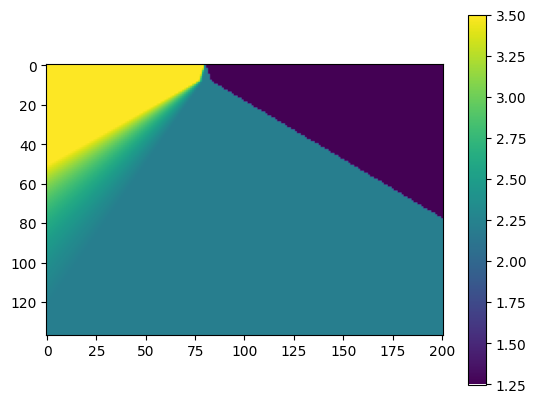

In [24]:
plt.imshow(a[:, 0, :])
plt.colorbar()

In [25]:
model = TFNO(
    n_modes=(16,), 
    in_channels=1,
    lifting_channels=64, 
    hidden_channels=64, 
    projection_channels=64, 
    out_channels=1, 
    non_linearity=torch.functional.F.relu)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')

batch_size = 32

dataset = torch.utils.data.TensorDataset(train_x, train_y)
dataloader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

learn_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)


The model has 308929 parameters.


  0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 0/100 | Loss: 3.277386
Epoch 10/100 | Loss: 0.051840
Epoch 20/100 | Loss: 0.021730
Epoch 30/100 | Loss: 0.017291
Epoch 40/100 | Loss: 0.014585
Epoch 50/100 | Loss: 0.009145
Epoch 60/100 | Loss: 0.004777
Epoch 70/100 | Loss: 0.003983
Epoch 80/100 | Loss: 0.003573
Epoch 90/100 | Loss: 0.003040
Training time: 32.56s


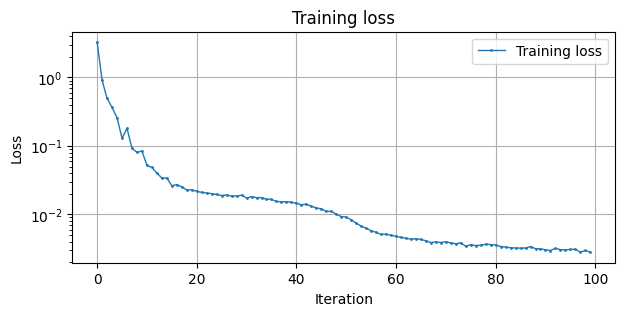

In [26]:
# Initialize lists
loss_train = []
loss_val = []
best_val_loss = np.inf

model.to(device)

# Time training
start_time = time.time()

# Training loop
n_epochs = 10
for epoch in tqdm(range(n_epochs), unit='epoch'):
    model.train()
    epoch_loss = 0

    for x, y in dataloader_train:
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update epoch loss
        epoch_loss += loss.item() * x.size(0) # Add batch loss

    # Compute average epoch loss
    epoch_loss /= len(dataset)

    # Append loss
    loss_train.append(epoch_loss)

    # Print epoch loss
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs} | Loss: {epoch_loss:.6f}')

# Time training
end_time = time.time()
print(f'Training time: {end_time - start_time:.2f}s')

save = 0
plot_loss(loss_train, loss_val, save=save)

(137, 1, 201)


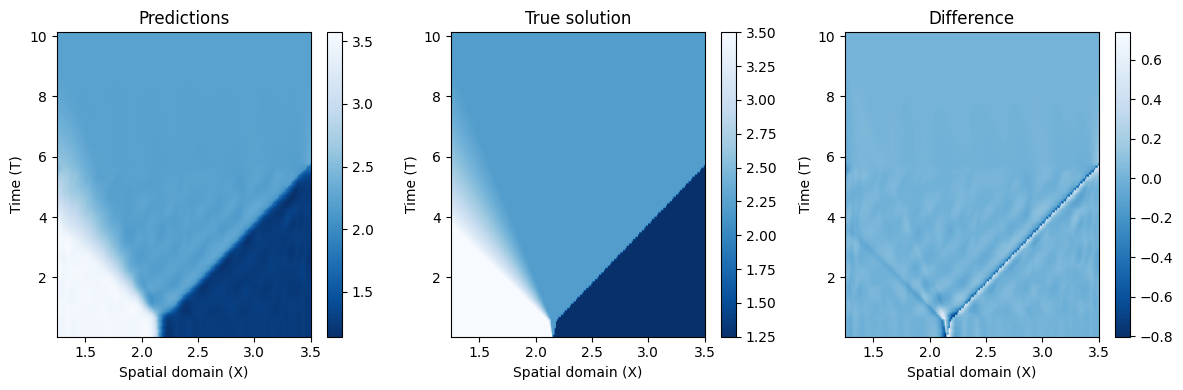

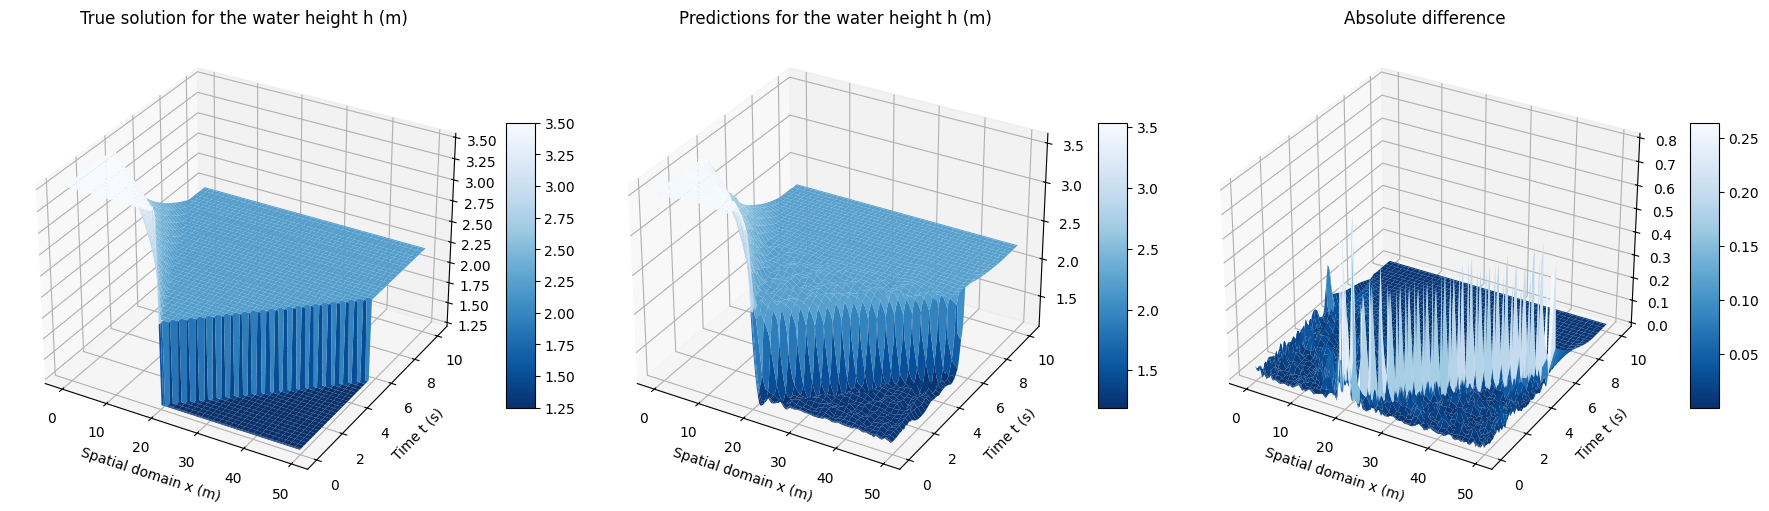

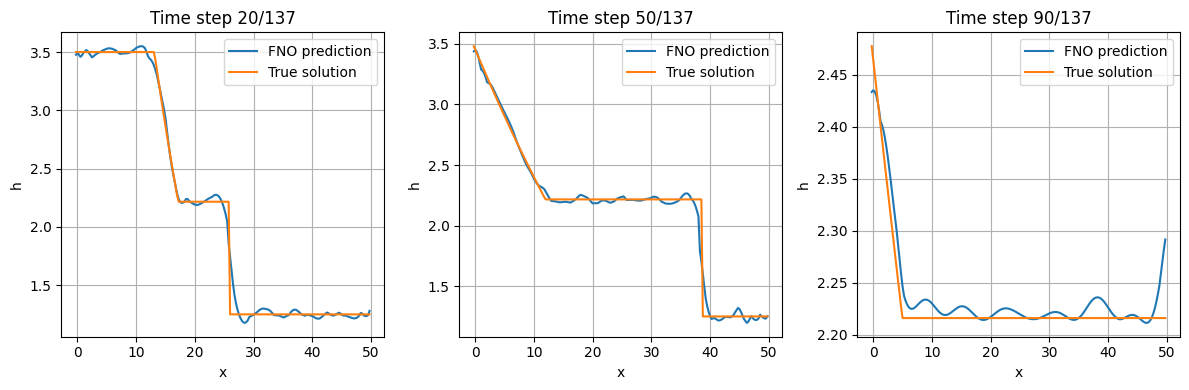

(137,)


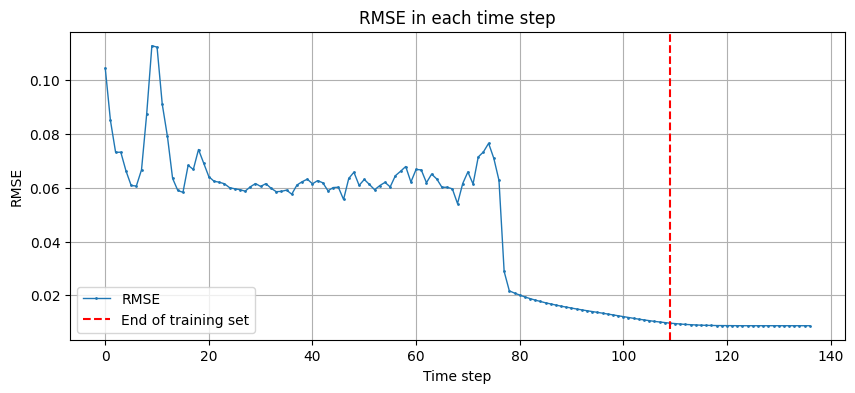

In [27]:
# Make predictions
pred_train = model(train_x).cpu().detach().numpy()
pred_test = model(test_x).cpu().detach().numpy()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train, pred_test], axis=0)
print(pred_all.shape)

plot_predictions_imshow(pred_all, train_x, val_x, test_x, u, x, time_all, save=False, figname='plots/predictions.pdf')
plot_predictions_3D(pred_all, u, mesh, time_all, save=False, figname='plots/predictions_3D.pdf')

indices = [20, 50, 90]
plot_predictions_time_steps(pred_all, u, mesh, indices, save=False, figname='plots/predictions_time_steps.pdf')
plot_RMSE(pred_all, u, n_train, save=False)

## Toro test case 1

Load data from h5 file.

In [56]:
filepath = r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\torotest1_t7.h5'
h_all, time_all, u_all, x = load_h5_file(filepath)

p_train = 0.7
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, mesh, a_with_mesh, u_with_mesh, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, x, p_train, p_val)

data_0
  'data_0' is a group containing:
    hexact_all
    time_all
    uexact_all
    xexact
'h_all' loaded with shape: (95, 201)
'u_all' loaded with shape: (95, 201)
'time_all' loaded with shape: (95, 1)
'x' loaded with shape: (1, 201)
n_train = 65, n_val = 18, n_test = 11


In [57]:
model = TFNO(
    n_modes=(16,), 
    in_channels=1,
    lifting_channels=64, 
    hidden_channels=64, 
    projection_channels=64, 
    out_channels=1, 
    non_linearity=torch.functional.F.relu)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')

batch_size = 32

# Create dataloaders
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

learn_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)


The model has 308929 parameters.


In [ ]:
# Initialize lists
loss_train = []
loss_val = []
best_val_loss = np.inf

model.to(device)

# Time training
start_time = time.time()

# Training loop
n_epochs = 500
for epoch in tqdm(range(n_epochs), unit='epoch'):
    model.train()
    epoch_train_loss = 0

    for x, y in dataloader_train:
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update epoch loss
        epoch_train_loss += loss.item() * x.size(0) # Add batch loss

    # Validation loss
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        epoch_val_loss = 0
        for x, y in dataloader_val:
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            # Update validation loss
            epoch_val_loss += loss.item() * x.size(0)

    # Compute average epoch loss
    epoch_train_loss /= len(train_dataset)
    epoch_val_loss /= len(val_dataset)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print epoch loss
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs}: Training loss: {epoch_loss:.6f}, Validation loss: {epoch_val_loss:.6f}')

# Time training
end_time = time.time()
print(f'Training time: {end_time - start_time:.2f}s')

save = 0
plot_loss(loss_train, loss_val, save=save, figname='plots/torotest1_loss.pdf')

  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch 0/500: Training loss: 0.002795, Validation loss: 0.140114
Epoch 10/500: Training loss: 0.002795, Validation loss: 0.030840
Epoch 20/500: Training loss: 0.002795, Validation loss: 0.026252
Epoch 30/500: Training loss: 0.002795, Validation loss: 0.018573
Epoch 40/500: Training loss: 0.002795, Validation loss: 0.018293
Epoch 50/500: Training loss: 0.002795, Validation loss: 0.016924
Epoch 60/500: Training loss: 0.002795, Validation loss: 0.015010
Epoch 70/500: Training loss: 0.002795, Validation loss: 0.014043
Epoch 80/500: Training loss: 0.002795, Validation loss: 0.013086
Epoch 90/500: Training loss: 0.002795, Validation loss: 0.013059
Epoch 100/500: Training loss: 0.002795, Validation loss: 0.012510
Epoch 110/500: Training loss: 0.002795, Validation loss: 0.013600
Epoch 120/500: Training loss: 0.002795, Validation loss: 0.011773
Epoch 130/500: Training loss: 0.002795, Validation loss: 0.012209
Epoch 140/500: Training loss: 0.002795, Validation loss: 0.011817
Epoch 150/500: Traini

Plot training and validation loss. Iteration = n_epochs x n_batches.

(94, 1, 201)


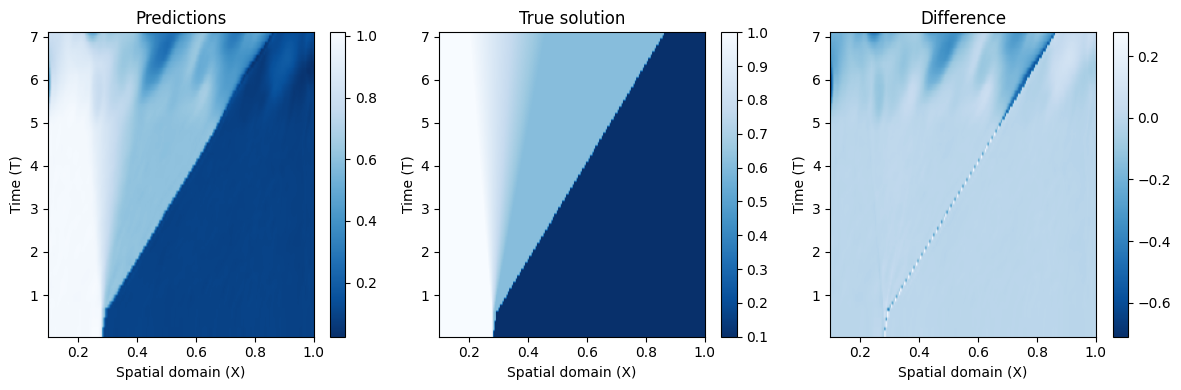

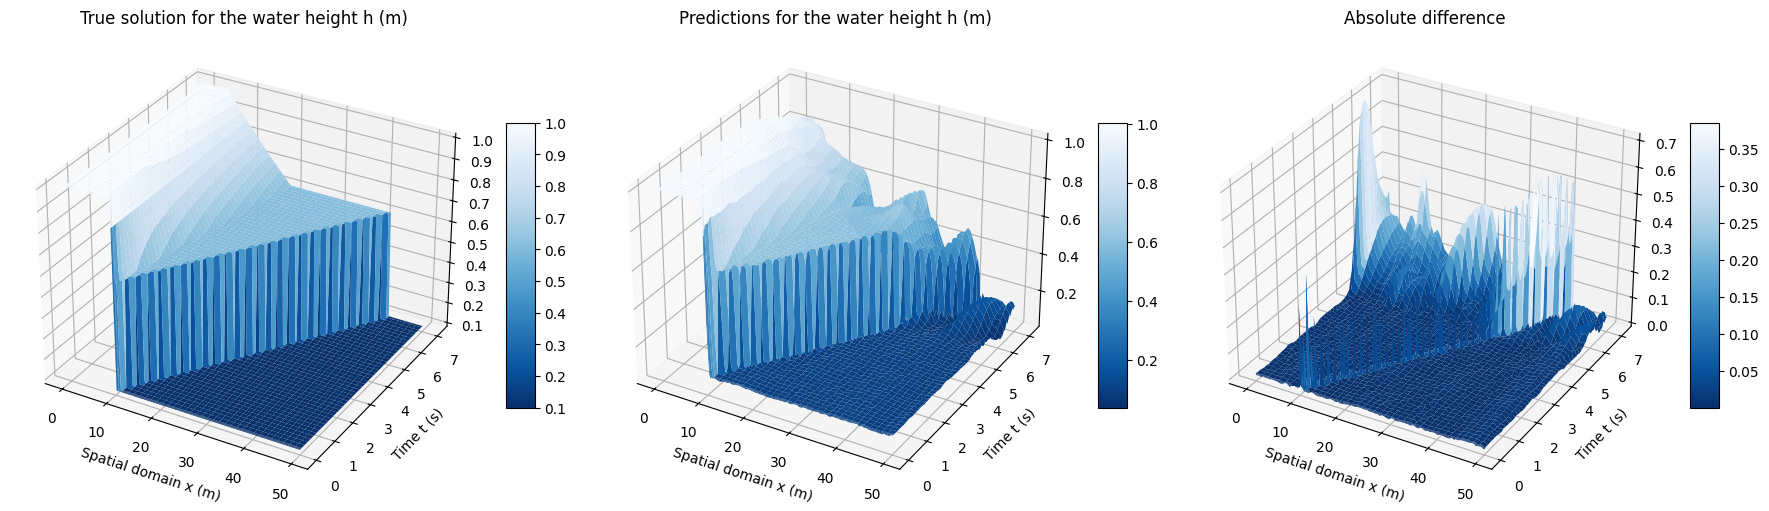

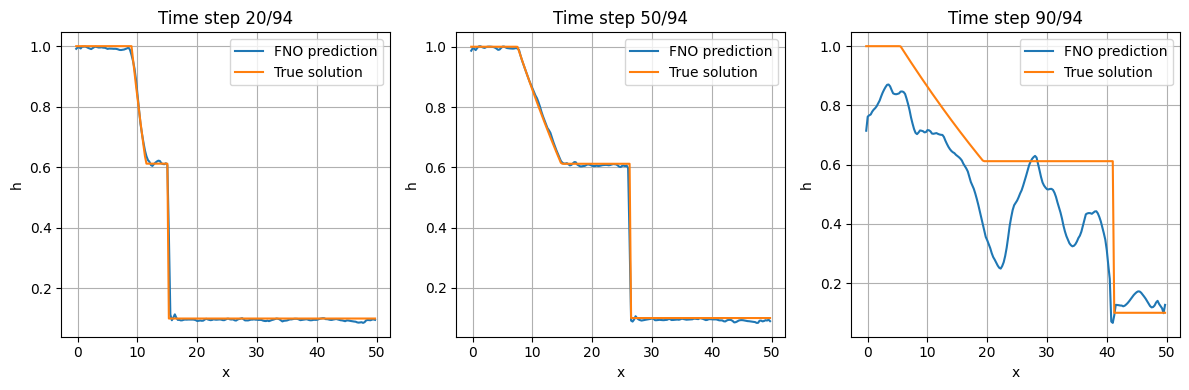

(94,)


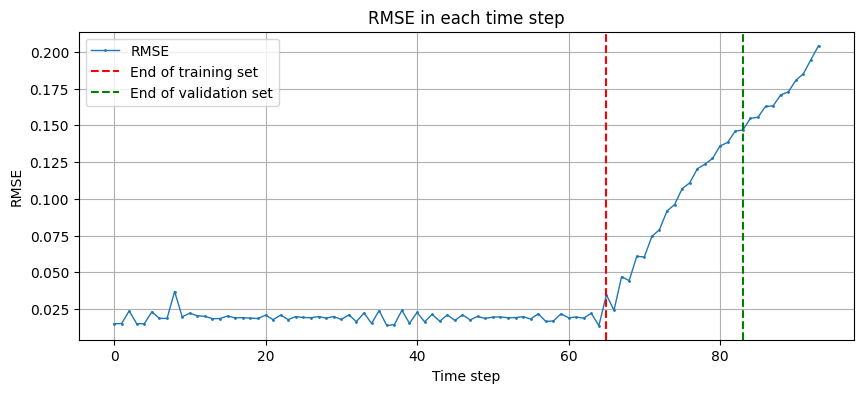

In [61]:
# Make predictions
pred_train = model(train_x).cpu().detach().numpy()
pred_val = model(val_x).cpu().detach().numpy()
pred_test = model(test_x).cpu().detach().numpy()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train, pred_val, pred_test], axis=0)
print(pred_all.shape)

plot_predictions_imshow(pred_all, train_x, val_x, test_x, u, x, time_all, save=save, figname='plots/torotest1_predictions.pdf')
plot_predictions_3D(pred_all, u, mesh, time_all, save=save, figname='plots/torotest1_predictions_3D.pdf')

indices = [20, 50, 90]
plot_predictions_time_steps(pred_all, u, mesh, indices, save=save, figname='plots/torotest1_predictions_time_steps.pdf')
plot_RMSE(pred_all, u, n_train, n_val, save=save, figname='plots/torotest1_RMSE.pdf')

## Toro test case 3

In [ ]:
filepath = r'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\torotest3_t4.h5'
h_all, time_all, u_all, x = load_h5_file(filepath)

p_train = 0.8
p_val = 0.0
p_test = 1 - p_train - p_val
n_train, n_val, n_test, mesh, a_with_mesh, u_with_mesh, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, x, p_train, p_val)

data_0
  'data_0' is a group containing:
    hexact_all
    time_all
    uexact_all
    xexact
'h_all' loaded with shape: (36, 201)
'u_all' loaded with shape: (36, 201)
'time_all' loaded with shape: (36, 1)
'x' loaded with shape: (1, 201)
n_train = 28, n_val = 0, n_test = 7


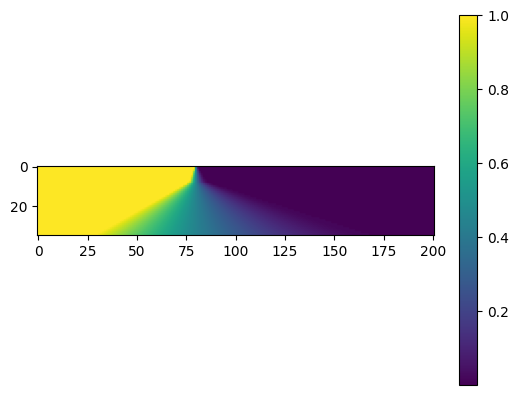

In [ ]:
plt.imshow(a[:,0,:])
plt.colorbar()

In [ ]:
model = TFNO(
    n_modes=(16,), 
    in_channels=1,
    lifting_channels=64, 
    hidden_channels=64, 
    projection_channels=64, 
    out_channels=1, 
    non_linearity=torch.functional.F.relu)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')

batch_size = 32

dataset = torch.utils.data.TensorDataset(train_x, train_y)
dataloader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

learn_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)


The model has 308929 parameters.


  0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 0/100 | Loss: 0.000000e+00
Epoch 10/100 | Loss: 0.000000e+00
Epoch 20/100 | Loss: 0.000000e+00
Epoch 30/100 | Loss: 0.000000e+00
Epoch 40/100 | Loss: 0.000000e+00
Epoch 50/100 | Loss: 0.000000e+00
Epoch 60/100 | Loss: 0.000000e+00
Epoch 70/100 | Loss: 0.000000e+00
Epoch 80/100 | Loss: 0.000000e+00
Epoch 90/100 | Loss: 0.000000e+00
Training time: 0.05s


C:\Users\Matteo\AppData\Local\Temp\ipykernel_5616\1137981533.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


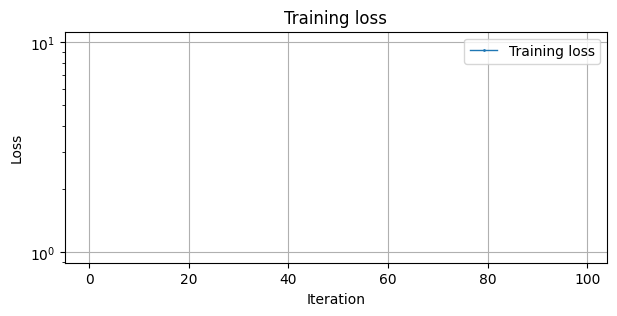

In [ ]:
# Initialize lists
loss_train = []
loss_val = []
best_val_loss = np.inf

model.to(device)

# Time training
start_time = time.time()

# Training loop
n_epochs = 100
for epoch in tqdm(range(n_epochs), unit='epoch'):
    model.train()
    epoch_loss = 0

    for x, y in dataloader_train:
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update epoch loss
        epoch_loss += loss.item() * x.size(0) # Add batch loss

    # Compute average epoch loss
    epoch_loss /= len(dataset)

    # Append loss
    loss_train.append(epoch_loss)

    # Print epoch loss
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs} | Loss: {epoch_loss:.6e}')

# Time training
end_time = time.time()
print(f'Training time: {end_time - start_time:.2f}s')

save = 0
plot_loss(loss_train, loss_val, save=save)

(35, 1, 201)


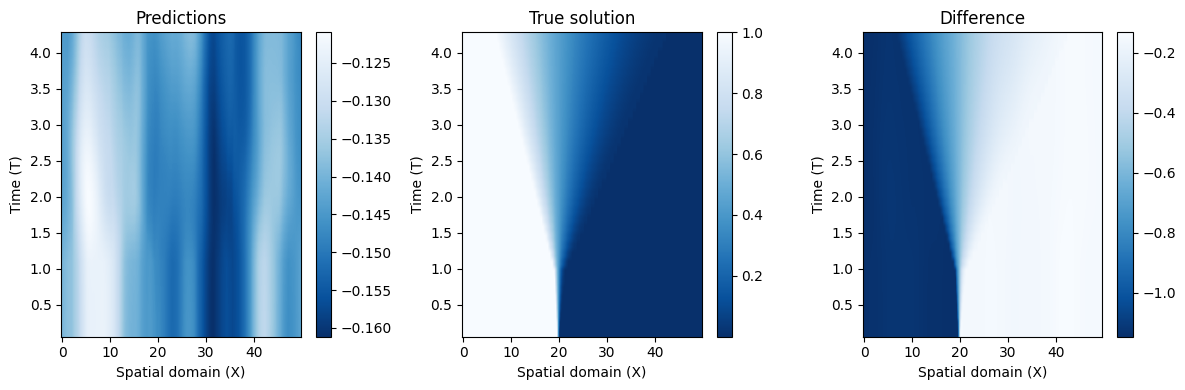

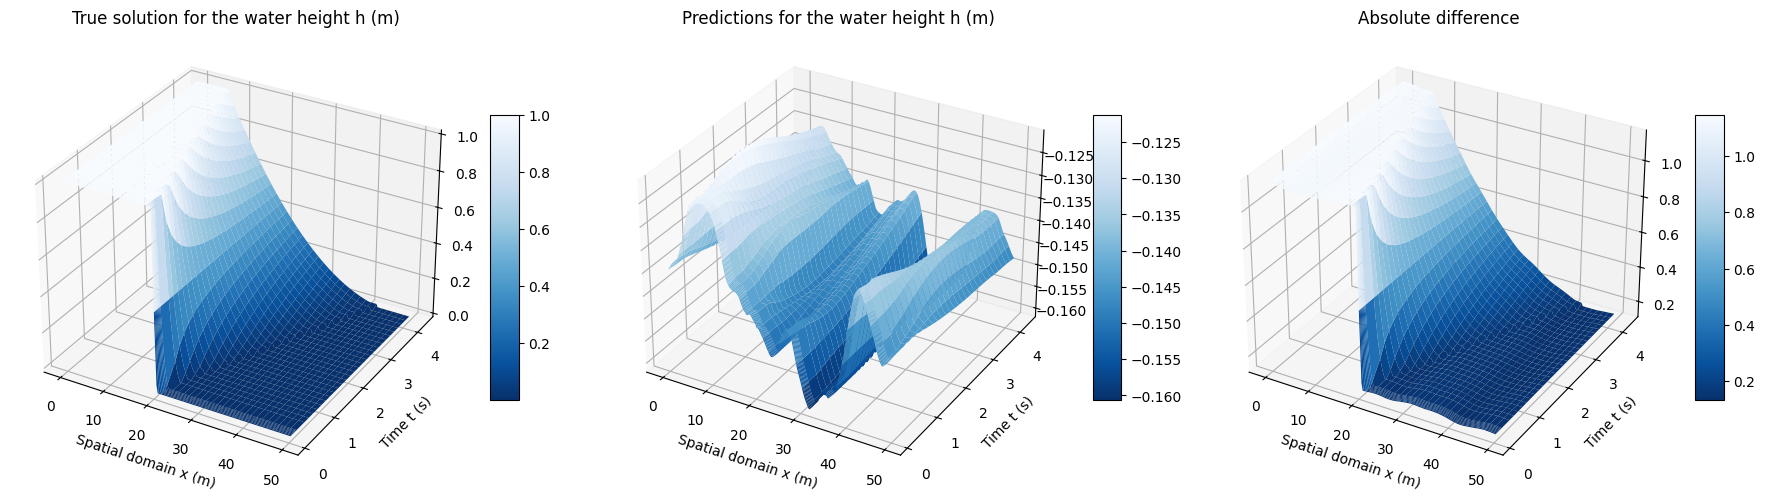

IndexError: index 50 is out of bounds for axis 0 with size 35

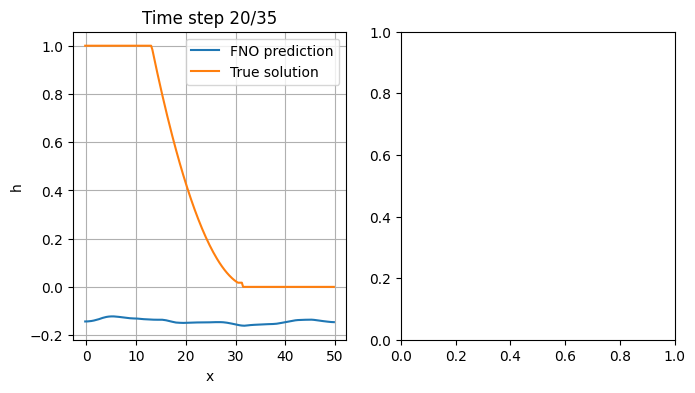

In [ ]:
# Make predictions
pred_train = model(train_x).cpu().detach().numpy()
pred_test = model(test_x).cpu().detach().numpy()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train, pred_test], axis=0)
print(pred_all.shape)

plot_predictions_imshow(pred_all, train_x, val_x, test_x, u, x, time_all, save=False, figname='plots/predictions.pdf')
plot_predictions_3D(pred_all, u, mesh, time_all, save=False, figname='plots/predictions_3D.pdf')

indices = [20, 50, 90]
plot_predictions_time_steps(pred_all, u, mesh, indices, save=False, figname='plots/predictions_time_steps.pdf')
plot_RMSE(pred_all, u, n_train, save=False)